In [1]:
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
from PIL import Image
from utils import read_mat_file, visualize_sample_dataset
from dataloader import SVHDDataset
import scipy.io

from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from model import VGG
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import os
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
# Train the model
from model import VGG16
#import cv2 

os.environ['TORCH_NNPACK'] = '0'

In [2]:
train_path = '/data/omscs_datasets/train/'
train_mat_file_path = train_path + 'digitStruct.mat'
test_path = '/data/omscs_datasets/train/'
test_mat_file_path = test_path + 'digitStruct.mat'
device = torch.device("cuda")

In [3]:
import random


class SVHDDigitNonDigitDataset(Dataset):
    
    def __init__(self, mat_file_path, image_dir, mode):
        # 파일 열기 및 데이터셋 구조 읽기
        with h5py.File(mat_file_path, 'r') as f:
            if mode == 'train':
                print('## train ##')
                self.digitStruct = f['digitStruct']
                self.bbox_refs = [obj_ref[0] for _, obj_ref in enumerate(self.digitStruct['bbox'])]
                self.name_refs = [obj_ref[0] for _, obj_ref in enumerate(self.digitStruct['name'])]
            else:
                print('## test ##')
                self.digitStruct = f
                self.bbox_refs = [f[key][()] for key in f['bbox'].keys()]
                self.name_refs = [f[key][()] for key in f['name'].keys()]

            self.length = len(self.digitStruct)

        self.file = h5py.File(mat_file_path, 'r')  # 파일 따로 열기
        self.image_dir = image_dir
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 이미지 및 레이블 정보 액세스
        bbox_data = self.file[self.bbox_refs[idx]]

        num_boxes = bbox_data['height'].shape[0]

        digit_samples = []
        non_digit_samples = []

        for i in (range(num_boxes)):
            # bbox 정보 로드
            height_ref = bbox_data['height'][i]
            width_ref = bbox_data['width'][i]
            top_ref = bbox_data['top'][i]
            left_ref = bbox_data['left'][i]
            label_ref = bbox_data['label'][i]

            try:
                height = self.file[height_ref[0]][()].item()
                width = self.file[width_ref[0]][()].item()
                top = self.file[top_ref[0]][()].item()
                left = self.file[left_ref[0]][()].item()
                label = self.file[label_ref[0]][()].item()
            except:
                height = height_ref[0]
                width = width_ref[0]
                top = top_ref[0]
                left = left_ref[0]
                label = label_ref[0]

            # 이미지 로드 및 크롭
            image_path = os.path.join(self.image_dir, str(idx + 1) + '.png')
            image = Image.open(image_path)
            cropped_image = image.crop((left, top, left + width, top + height))
            cropped_image = self.transform(cropped_image)

            digit_sample = {
                'image': cropped_image,
                'label': 1,
                'name': image_path
            }
            digit_samples.append(digit_sample)
    
        if num_boxes == 1:
            try:
                # 임의의 위치와 크기로 박스 생성
                left = random.randint(0, image.size[0] - 32)
                top = random.randint(0, image.size[1] - 32)

                # Digit와 겹치는지 확인
                try:
                    d_height = self.file[height_ref[0]][()].item()
                    d_width = self.file[width_ref[0]][()].item()
                    d_top = self.file[top_ref[0]][()].item()
                    d_left = self.file[left_ref[0]][()].item()
                    label = self.file[label_ref[0]][()].item()
                except:
                    d_height = height_ref[0]
                    d_width = width_ref[0]
                    d_top = top_ref[0]
                    d_left = left_ref[0]
                    label = label_ref[0]

                if not (left + 32 <= d_left or left >= d_left + d_width or
                        top + 32 <= d_top or top >= d_top + d_height):
                    pass

                # Non-digit 영역 크롭
                cropped_image = image.crop((left, top, left + 32, top + 32))
                cropped_image = self.transform(cropped_image)

                non_digit_sample = {
                    'image': cropped_image,
                    'label': 0,
                    'name': image_path
                }
                non_digit_samples.append(non_digit_sample)
                
            except:
                pass

        # Digit 및 Non-Digit 샘플 결합
        return digit_samples +  non_digit_samples

In [4]:
train_dataset = SVHDDigitNonDigitDataset(train_mat_file_path, train_path,mode='train')

## train ##


In [5]:
train_images = []
train_labels = []
for t in tqdm(train_dataset):
    for tt in t:
        train_images.append(tt['image'])
        train_labels.append(tt['label'])

33402it [02:56, 189.62it/s]          


In [6]:
print(train_labels.count(0), train_labels.count(1))

3828 73257


In [7]:
num = 200
print(train_images[num].shape, train_labels[num])

torch.Size([3, 32, 32]) 1


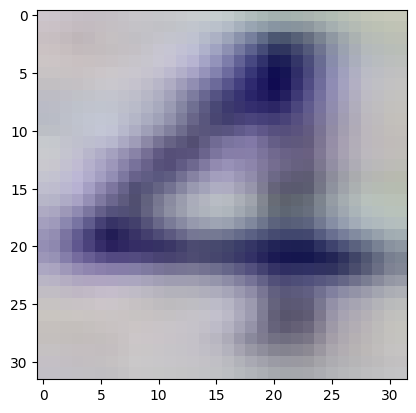

In [8]:
np_image = train_images[num].numpy().transpose(1,2,0)
plt.imshow(np_image)

In [9]:
from torchvision import transforms

# 데이터 증강을 위한 변환 정의
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# 레이블 별로 이미지 분류
images_label_0 = [train_images[i] for i in range(len(train_labels)) if train_labels[i] == 0]
images_label_1 = [train_images[i] for i in range(len(train_labels)) if train_labels[i] == 1]

# 레이블 0의 이미지에 대한 데이터 증강 수행
augmented_images_label_0 = []
for img in images_label_0:
    augmented_image = augmentation_transforms(img)
    augmented_images_label_0.append(augmented_image)

# 증강된 이미지와 원본 이미지를 합침
balanced_images_label_0 = images_label_0 + augmented_images_label_0

# 이미지와 레이블 합치기
balanced_train_images = balanced_images_label_0 + images_label_1
balanced_train_labels = [0] * len(balanced_images_label_0) + [1] * len(images_label_1)

# 결과 확인
print(len(balanced_train_images), len(balanced_train_labels))
print(balanced_train_labels.count(0), balanced_train_labels.count(1))

80913 80913
7656 73257


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        #if self.transform:
        #    print('image:', image.shape)
        #    image = self.transform(image)

        # Return the image and label as a dictionary or tuple
        sample = {'image': image, 'label': label}

        return sample

In [11]:
print(len(balanced_train_images), len(balanced_train_labels))
train_dataset = CustomDataset(balanced_train_images, balanced_train_labels, transform=train_transform)

80913 80913


In [12]:
# Specify the lengths of the training and testing sets
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size

# Use random_split to split the dataset
train_data, test_data = random_split(train_dataset, [train_size, test_size])
print(f'train_data:{len(train_data)}, test_data:{len(test_data)}')

train_data:64730, test_data:16183


In [13]:
# Step 4: Create a DataLoader for your dataset
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
print(len(train_loader), len(test_loader))

506 127


In [14]:
def test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, labels = batch['image'], batch['label']
            inputs = inputs.to(torch.float32).to(device)
            labels = labels.to(torch.float32).to(device)
            labels = labels.long()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [15]:
def train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5):
    
    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        print('## epoch ##', epoch)
        
        for batch in tqdm(train_loader):
            inputs, labels = batch['image'], batch['label']
            inputs = inputs.to(torch.float32).to(device)
            labels = labels.to(torch.float32).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.long()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = test_accuracy(model, test_loader, device)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Test Accuracy: {epoch_accuracy}%")
        
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), 'best_digit_recog_model.pth')
            print(f"New best model saved with accuracy: {epoch_accuracy}%")

In [16]:
#model = VGG(num_classes=11).to(device)
model =  VGG16(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Train the model
model.to(device)
# train(model, train_loader, criterion, optimizer, num_epochs=5)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [17]:
train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5)

## epoch ## 0


  0%|          | 0/506 [00:00<?, ?it/s]/root/miniconda3/envs/cv_proj/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 127/127 [00:00<00:00, 144.31it/s]


Epoch 1/5, Loss: 0.143869395047544, Test Accuracy: 95.85985293208923%
New best model saved with accuracy: 95.85985293208923%
## epoch ## 1


100%|██████████| 127/127 [00:00<00:00, 151.83it/s]


Epoch 2/5, Loss: 0.05969843071822828, Test Accuracy: 98.16474077735896%
New best model saved with accuracy: 98.16474077735896%
## epoch ## 2


100%|██████████| 127/127 [00:00<00:00, 153.69it/s]


Epoch 3/5, Loss: 0.0424681393541911, Test Accuracy: 98.442810356547%
New best model saved with accuracy: 98.442810356547%
## epoch ## 3


100%|██████████| 127/127 [00:00<00:00, 153.26it/s]


Epoch 4/5, Loss: 0.02814301984658899, Test Accuracy: 98.38719644070939%
## epoch ## 4


100%|██████████| 127/127 [00:00<00:00, 155.23it/s]

Epoch 5/5, Loss: 0.02196910385094885, Test Accuracy: 98.38719644070939%
